In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tqdm
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
import sys
import warnings
warnings.filterwarnings('ignore')
#sns.set_context('talk')
#sns.set_style('whitegrid')
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']

modulename = 'multiprocess' #essing

if modulename in sys.modules:
    print(modulename, 'has been already imported')


multiprocess has been already imported


In [2]:
def calc_plam(num_pulses,lam1,lam2): #Explain
    pow_lam1 = np.power(lam1,num_pulses)
    pow_lam2 = np.power(lam2,num_pulses)
    exp_lam1 = np.exp(-lam1)
    exp_lam2 = np.exp(-lam2)
    return pow_lam1*exp_lam1/(pow_lam1*exp_lam1+pow_lam2*exp_lam2)

def compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1):
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2+sig_dN**2)
    phigh = norm.cdf((Nps-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_phigh(Np,Nb,sig_dN,sig_Np):
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_sq(Np,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_lin(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sig = np.sqrt(sig_Np**2+sig_dN**2)   #Why this is not multiplied by 2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_lin_sub(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18): #ksig,sig_0,sub
    #sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sub_Np = sig_0*np.ones(4)
    sig_Np = np.concatenate([sub_Np,ksig*(np.arange(5,Nmax+1,1))+sig_0]) # + sig_0
    print(sig_Np)
    sig = np.sqrt(sig_Np**2+sig_dN**2)   #Why this is not multiplied by 2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_pow(Np,Nb,sig_dN,ksig,ind,Nmin=1,Nmax=18):
    sig_Np = ksig*np.power((np.arange(Nmin,Nmax+1)),ind)
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_const(Np,Nb,sig_dN,Nmin=1,Nmax=18):
    sig = sig_dN
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    return compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    
def compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1):
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin_sub(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18): #ksig,sig_0,sub
    #sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sub_NP = np.zeros(4)
    sig_Np = np.concatenate([sub_NP,ksig*(np.arange(5,Nmax+1,1))+sig_0]) # + sig_0
    #sig_Np[0:4] = sub
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_pow(choices,Nps,Nb,sig_dN,ksig,ind,Nmin=1,Nmax=18):
    sig_Np = ksig*np.power((np.arange(Nmin,Nmax+1)),ind)
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_const(choices,Nps,Nb,sig_dN,Nmin=1,Nmax=18):
    sig_Np = np.zeros((Nmax-Nmin+1,))
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def get_pulses(choices,cum_odor,min_pulse,max_pulse):
    all_Nps = np.ceil(cum_odor).astype(np.int)
    ind_selected = np.logical_and(all_Nps>=min_pulse,all_Nps<=max_pulse)
    return choices[ind_selected], all_Nps[ind_selected]

In [3]:
a = 7
b = np.zeros(4)
c = a*b
print(c)

d = 6
e = d*(np.arange(5, 22, 1))
print(e)
f = np.concatenate([c,e])
print(f)

[0. 0. 0. 0.]
[ 30  36  42  48  54  60  66  72  78  84  90  96 102 108 114 120 126]
[  0.   0.   0.   0.  30.  36.  42.  48.  54.  60.  66.  72.  78.  84.
  90.  96. 102. 108. 114. 120. 126.]


In [6]:

# compute psychjometrics of each animal

path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/Final'
#print(path)
dir_list = os.listdir(path)
#print(dir_list)

num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20

pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_high_choices_list = list()
all_cum_odor_list = list()
all_correct_trials_list = list()

animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],
#type(animal_list)

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    num_all_trials = 0

    all_cum_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))

    #print(fname_list)
    
    for i_file in range(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):  #if os.path.isfile(session_fname):
            #print('holaz')
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                #print(session_list[0])
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 5:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                        #if session_list[0]['low_count'] < 5:


                            num_trials = session['num_trials']
                            #print(session_fname, session_list[0]['high_count'], session_list[0]['low_count'])
                            non_idle_trials = np.invert(session['idle_trials'])
                            #print(len(non_idle_trials))


                            correct_trials = session['correct_trials'][non_idle_trials]
                            high_trials = session['high_trials'][non_idle_trials]
                            low_trials = session['low_trials'][non_idle_trials]
                            high_choices = (correct_trials==high_trials)
                            trial_odor = session['trial_odor'][non_idle_trials]
                            cum_odor = trial_odor.sum(axis=1)/5000



                            all_correct_trials = np.append(all_correct_trials,correct_trials)
                            all_high_trials = np.append(all_high_trials,high_trials)
                            all_high_choices = np.append(all_high_choices,high_choices)
                            all_cum_odor = np.append(all_cum_odor,cum_odor)
            
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        print(len(all_low_trials), bad_trials.sum(), good_trials.sum())    
    all_correct_trials_list.append(all_correct_trials)
    all_high_choices_list.append(all_high_choices)
    all_cum_odor_list.append(all_cum_odor)

    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)
    


176 3 173
344 2 342
514 1 513
745 3 742
1066 3 1063
1403 1 1402
1600 0 1600
1752 5 1747
1928 1 1927
2249 2 2247
2549 2 2547
2829 0 2829
3151 4 3147
3484 1 3483
3635 5 3630
3913 14 3899
4137 4 4133
4388 7 4381
249 2 247
482 1 481
697 2 695
937 2 935
1155 2 1153
1478 2 1476
1738 2 1736
1971 1 1970
2340 5 2335
2547 2 2545
2759 2 2757
2865 0 2865
3131 1 3130
3377 3 3374
3637 2 3635
3916 1 3915
4143 2 4141
4393 2 4391
4554 2 4552
4807 8 4799
5098 9 5089
5328 1 5327
230 1 229
370 0 370
605 4 601
827 4 823
1100 4 1096
1385 1 1384
1745 4 1741
2065 3 2062
2215 2 2213
2458 3 2455
2826 4 2822
3132 4 3128
3428 3 3425
3508 2 3506
3741 8 3733
3904 6 3898
4087 9 4078
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0

In [7]:
sns.set_style('ticks')
sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2, "legend.fontsize":14})
sns.despine()

print(len(all_correct_trials_list[6]))

1291


<Figure size 432x288 with 0 Axes>

20
20


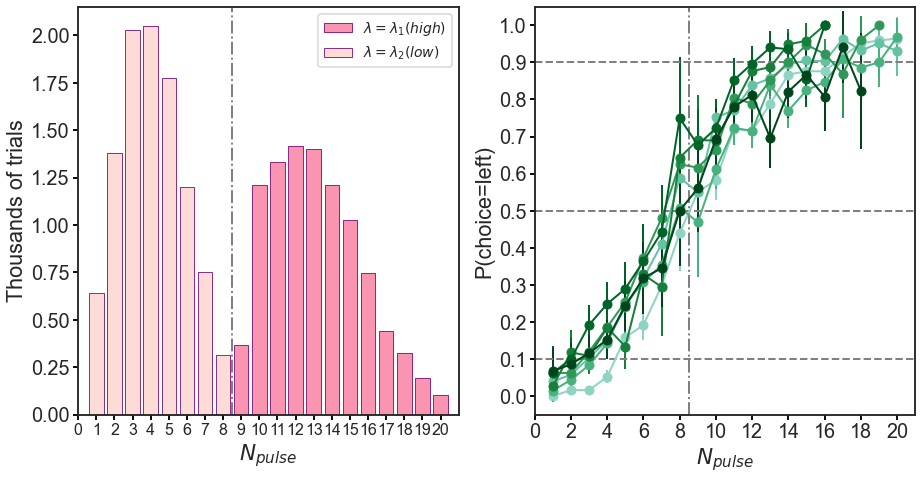

In [8]:
# Plot basic psychometric of each animal

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))


colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, len(animal_list)))
c_2 = plt.cm.get_cmap('RdPu')

fig = plt.figure(figsize=(15,7.5))
#fig.suptitle('Decision psychometrics of pulse estimation',size=25)

animals_legend = animal_list
print(len(phigh[:,1]))
print(len(pulse_bins))

plt.subplot(1,2,2)

for i in range(len(phigh_list)):
    phigh = phigh_list[i]
    plt.errorbar(pulse_bins,y=phigh[0:20,0],yerr=phigh[0:20,1],marker='o',color=colors[i])
#plt.legend(animals_legend)
plt.xlabel('$N_{pulse}$')
#plt.grid(False)
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(-0.05,1.05)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=left)')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,21)
plt.tick_params(axis='both', length=5, color='black', direction = 'out')



plam_bins = calc_plam(pulse_bins,12.5,4.16667)
# plt.subplot(2,2,2)
# for i in range(len(phigh_list)):
#     phigh = phigh_list[i]
#     plt.errorbar(plam_bins,y=phigh[:,0],yerr=phigh[:,1],marker='o',color=colors[i])
# plt.xlabel('$P(\lambda=\lambda_1|N_{pulse})$')
# #plt.grid(False)
# plt.axhline(y=0.1,color='gray',linestyle='--')
# plt.axhline(y=0.5,color='gray',linestyle='--')
# plt.axhline(y=0.9,color='gray',linestyle='--')
# plt.axvline(x=0.5,color='gray',linestyle='-.')
# plt.ylim(-0.05,1.05)
# plt.yticks(np.linspace(0,1,11))
# plt.ylabel('P(choice=left)')


plt.subplot(1,2,1)
bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:],bin_counts[half_num_bins:]/1000,color=c_2(0.40), edgecolor = c_2(0.90), linewidth=0.8)
plt.bar(pulse_bins[:half_num_bins],bin_counts[:half_num_bins]/1000,color=c_2(0.15), edgecolor = c_2(0.90), linewidth=0.8)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'])
plt.grid(False)
plt.xlim(0,21)
plt.xticks(np.linspace(0,20,21), fontsize = 16)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('$N_{pulse}$')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')


#fig.savefig(savepath + 'behavior_summary_all_20.svg',format='svg')
#fig.savefig(savepath + 'behavior_summary_all_20.png',format='png')
plt.show()

In [25]:
print(bin_counts)

[ 642. 1378. 2026. 2048. 1773. 1201.  751.  312.  368. 1213. 1330. 1416.
 1398. 1209. 1025.  746.  441.  323.  193.  103.]


In [22]:
num_processes = 16
N_bootstrap = 4000
num_iter = 1000
batch_iter = 100
bound = (0.4,20)

bounds = list()
for i in range(18):
    bounds.append(bound)
num_batch = num_iter//batch_iter
#resx_list = list()

for i in range(len(all_correct_trials_list[3:])):
    res_array = np.zeros((18,num_iter))
    all_correct_trials = all_correct_trials_list[i]
    all_high_choices = all_high_choices_list[i]
    all_cum_odor = all_cum_odor_list[i]
    
    def worker(x):
        #np.random.seed(77)

        ind_bootstrap = np.random.randint(0,len(all_correct_trials),size=(N_bootstrap,))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]

        choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,16)

        def loss(x):
            Nb = x[0]
            sig_dN = x[1]
            sig_Np = x[2:]
            return -compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

        x0 = 9.5+np.random.rand(18)*5
        res = minimize(loss,x0,bounds=bounds) #, method='BFGS', options={'norm':1})
        return res.x
    
    output = list()

    with mp.Pool(processes=16) as pool:
        for i in tnrange(num_batch):
            batch_output = pool.map(worker,range(batch_iter))
            output.extend(batch_output)
        pool.close()

    resi_array = np.concatenate(output).reshape(-1,18).transpose()

    resix =np.zeros((18,2))
    resix[:,0] = resi_array.mean(1)
    resix[:,1] = 1.69*resi_array.std(1)/np.sqrt(num_iter)
    resx_list.append(resix)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
print(resx_list)
print(len(resx_list))
resx_list.pop(3)
resx_list.pop(3)
resx_list.pop(3)
resx_list.pop(3)
print(len(resx_list),resx_list)


[array([[ 8.6416958 ,  0.05435605],
       [ 0.78658699,  0.03161078],
       [ 1.95843833,  0.17441497],
       [ 3.18939947,  0.0722741 ],
       [ 2.63622969,  0.06174685],
       [ 2.7388832 ,  0.04661069],
       [ 4.63534744,  0.12530899],
       [ 4.26936836,  0.14490724],
       [ 5.02211537,  0.19353094],
       [ 6.68927024,  0.31338359],
       [10.5839716 ,  0.28768256],
       [ 8.10301604,  0.28072825],
       [ 5.66515542,  0.1992669 ],
       [ 7.42871848,  0.16447018],
       [ 6.59306427,  0.12070462],
       [ 5.53659654,  0.10844369],
       [ 6.21080136,  0.10380548],
       [ 6.85122292,  0.09328184],
       [ 6.89351257,  0.10148531],
       [ 6.27750467,  0.12755925],
       [ 6.11258524,  0.18378779],
       [ 6.44418047,  0.20130787]]), array([[ 7.82463316,  0.03813674],
       [ 0.90646491,  0.04131834],
       [ 4.34895601,  0.10791287],
       [ 3.62567446,  0.05873311],
       [ 3.69310313,  0.05690775],
       [ 3.74383435,  0.07808862],
       [ 4.455735

In [2]:
# plot noise estimation result
type(animal_list)
#print(len(resx[2:,0]))
#print(len(np.arange(1,27)))

animals_legend = animal_list

fig = plt.figure(figsize=(15,15))
fig.suptitle('MLE estimation of pulse estimation noise',size=30)
plt.subplot(2,2,2)
Nb_array = np.zeros((len(resx_list),2))
sig_dN_array = np.zeros((len(resx_list),2))
for i in range(len(resx_list)):
    resx = resx_list[i]
    if i <3:
        plt.errorbar(x=np.arange(1,21),y=resx[2:,0],yerr=resx[2:,1],marker='o',color=colors[i],linestyle='')
        Nb_array[i,:] = resx[0,:]
        sig_dN_array[i,:] = resx[1,:]
    else:
        plt.errorbar(x=np.arange(1,17),y=resx[2:,0],yerr=resx[2:,1],marker='o',color=colors[i],linestyle='')
        Nb_array[i,:] = resx[0,:]
        sig_dN_array[i,:] = resx[1,:]
plt.xticks(np.linspace(0,20,11))
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_{N}$')
#plt.ylim(0,18)


plt.legend(animals_legend, bbox_to_anchor=(0.5, -0.25), loc="center left", ncol=3, fontsize='x-small')

plt.axvline(x=8.5,color='gray',linestyle='-.')

plt.subplot(2,2,1)
for i in range(len(resx_list)):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color=colors[i])
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,(len(animal_list)+1)),animal_list, fontsize=11)
#plt.xlabel('Mouse ID')
plt.ylabel('$N_{boundary}$')

plt.subplot(2,2,3)
for i in range(len(resx_list)):
    plt.bar(x=i+1,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color=colors[i])

plt.xticks(np.arange(1,(len(animal_list)+1)),animal_list, fontsize=11)
#plt.xlabel('Mouse ID')
plt.ylabel('$\sigma_{boundary}$')

plt.subplot(2,2,4)
for i in range(len(resx_list)):
    resx = resx_list[i]
    phigh = phigh_list[i]
    if i <3:
        phigh_est = compute_phigh(np.arange(1,21),resx[0,0],resx[1,0],resx[2:,0])
        #plt.plot(np.arange(1,21),phigh_est,color=colors[i])
        plt.errorbar(np.arange(1,21),phigh[0:20,0],yerr=phigh[0:20,1],color=colors[i],marker='o',linestyle='')
    else:
        phigh_est = compute_phigh(np.arange(1,17),resx[0,0],resx[1,0],resx[2:,0])
        plt.plot(np.arange(1,17),phigh_est,color=colors[i])
        plt.errorbar(np.arange(1,17),phigh[0:16,0],yerr=phigh[0:16,1],color=colors[i],marker='o',linestyle='')
plt.xticks(np.linspace(0,20,11))
fit_list = ['[fit' + str(animalito) + ']' for animalito in animal_list]
final_list = fit_list + animal_list
#print(final_list)

#animals_legend2 = animal_list
#plt.legend(animals_legend2, loc='best', ncol=3, fontsize='x-small')
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1.1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')

#fig.savefig(savepath + 'numeric_approximation_error_estimate_18.svg',format='svg')
#fig.savefig(savepath + 'numeric_approximation_error_estimate_18.png',format='png')
plt.show()

NameError: name 'animal_list' is not defined

In [45]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])
    
phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    

    
print(selected)
print(selected_correct)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1.]


[0.02959502 0.05297533 0.08983218 0.13916016 0.22560632 0.29725229
 0.37416778 0.55128205 0.60054348 0.67023908 0.76240602 0.78742938
 0.83333333 0.86683209 0.88682927 0.89276139 0.92970522 0.92260062] [0.01130329 0.01019717 0.01073603 0.01292529 0.01677602 0.02228833
 0.02984207 0.04758642 0.04314891 0.02281239 0.01972294 0.01837437
 0.01684484 0.01651356 0.01672291 0.01914523 0.02057319 0.02512818]


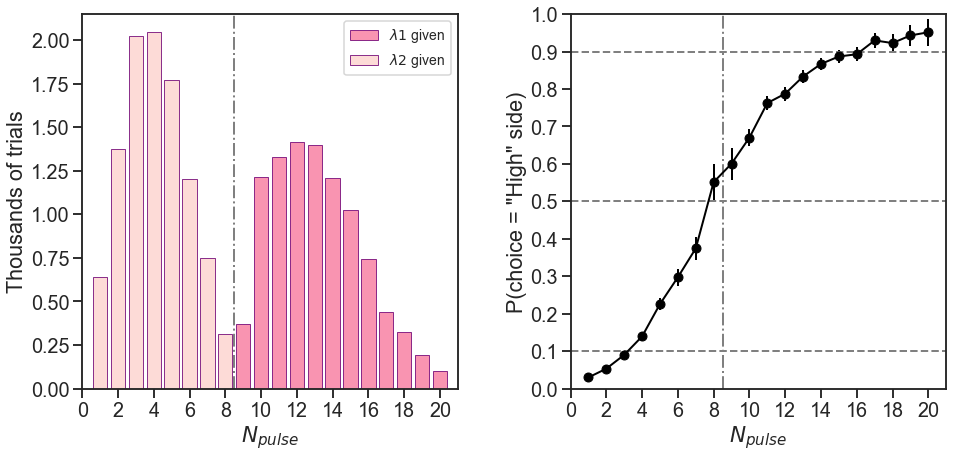

In [46]:
# Plot basic psychometric of pooled data

fig = plt.figure(figsize=(15,6.5))

#fig.suptitle('Decision psychomatrics of pulse estimation pooled across animals',size=25)
plt.subplot(1,2,2)
plt.errorbar(x=pulse_bins[0:20],y=phigh[0:20,0],yerr=phigh[0:20,1],marker='o',color='black')
plt.xlabel('$N_{pulse}$')
print(phigh[0:18,0], phigh[0:18,1])
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,21)

plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = "High" side)')
plt.xticks(np.linspace(0,20,11))

plam_bins = calc_plam(pulse_bins,12.5,4.16667)
# plt.subplot(1,3,2)

# plt.errorbar(plam_bins[0:20],y=phigh[0:20,0],yerr=phigh[0:20,1],marker='o',color='black')
# plt.xlabel('$P(\lambda=\lambda_1|N_{pulse})$')
# plt.axhline(y=0.1,color='gray',linestyle='--')
# plt.axhline(y=0.5,color='gray',linestyle='--')
# plt.axhline(y=0.9,color='gray',linestyle='--')
# plt.ylim(0,1)
# plt.yticks(np.linspace(0,1,11))
# plt.ylabel('P(choice=high)')

plt.subplot(1,2,1)
bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[8:],bin_counts[8:]/1000,color=c_2(0.40), edgecolor = c_2(0.90), linewidth=0.8)
plt.bar(pulse_bins[:8],bin_counts[:8]/1000,color=c_2(0.15), edgecolor = c_2(0.90), linewidth=0.8)
plt.legend(['$\lambda1$ given','$\lambda2$ given'])
plt.xlim(0,21)
plt.xticks(np.linspace(0,20,11))#, fontsize = 14)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('$N_{pulse}$')
plt.ylabel('Thousands of trials')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3)

#fig.savefig(savepath + 'behavior_psychometric_curve_pooled_20.svg',format='svg', bbox_inches='tight')
#fig.savefig(savepath + 'behavior_psychometric_curve_20.png',format='png', bbox_inches='tight')
plt.show()

In [47]:
num_processes = 16
N_bootstrap = 10000
num_iter = 1000
batch_iter = 100
bound = (0.6,50)


bounds = list()
for i in range(22):
    bounds.append(bound)
bounds[1] = (0,50)
num_batch = num_iter//batch_iter

res_array = np.zeros((22,num_iter))

    
def worker(x):
    #np.random.seed(0)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        sig_Np = x[2:]
        return -compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

    x0 = 6+np.random.rand(22)*5
    x0[1] = 0
    res = minimize(loss,x0,bounds=bounds,method='BFGS',options={'norm':2})
    #res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':100000})

    return res.x

output = list()

p = mp.Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,22).transpose()

resx_pool =np.zeros((22,2))
resx_pool[:,0] = res_array.mean(1)
resx_pool[:,1] = res_array.std(1)
#resx_pool[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
print(resx_pool)

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 7.35363954e+00  3.98756740e-01]
 [-1.02715534e-04  5.40745016e-04]
 [ 3.37151521e+00  2.81029037e-01]
 [ 3.29478272e+00  2.92910897e-01]
 [ 3.25704487e+00  3.15225753e-01]
 [ 3.01284723e+00  8.86879007e-01]
 [ 3.15899212e+00  5.32195219e-01]
 [ 2.61625865e+00  8.40930508e-01]
 [ 1.15341595e+00  1.34932982e+00]
 [ 8.60075931e+00  3.89768466e+00]
 [ 7.32875663e+00  5.47047978e+00]
 [ 6.05113646e+00  1.11353090e+00]
 [ 5.09008618e+00  6.88339632e-01]
 [ 5.78730830e+00  6.54894248e-01]
 [ 5.80600041e+00  5.60668194e-01]
 [ 6.00575205e+00  4.84511437e-01]
 [ 6.37096128e+00  5.60482926e-01]
 [ 7.08413109e+00  6.00058468e-01]
 [ 6.51558552e+00  5.65898662e-01]
 [ 7.50368668e+00  7.97543910e-01]
 [ 7.69500437e+00  1.17321236e+00]
 [ 7.50379381e+00  1.80400574e+00]]


In [13]:
res_array = np.concatenate(output).reshape(-1,22).transpose()
print(resx_pool)
resx_pool =np.zeros((22,2))
resx_pool[:,0] = res_array.mean(1)
resx_pool[:,1] = res_array.std(1)

[[ 7.66874413e+00  5.32032436e-01]
 [-2.02177297e-05  1.40990066e-04]
 [ 3.52237571e+00  3.65649013e-01]
 [ 3.38293668e+00  9.90078933e-01]
 [ 3.49779381e+00  4.06767284e-01]
 [ 3.38685996e+00  5.07913377e-01]
 [ 3.54207845e+00  7.82057156e-01]
 [ 3.16511378e+00  1.08119012e+00]
 [ 2.43939931e+00  2.17700541e+00]
 [ 9.35313868e+00  3.02489757e+00]
 [ 6.74128129e+00  5.51977698e+00]
 [ 5.21426904e+00  1.75766794e+00]
 [ 4.62419868e+00  8.33918754e-01]
 [ 5.45172632e+00  7.63344544e-01]
 [ 5.51145463e+00  5.97408381e-01]
 [ 5.72991622e+00  5.87335773e-01]
 [ 6.09880324e+00  4.95928624e-01]
 [ 6.67249201e+00  5.79961016e-01]
 [ 6.26594364e+00  6.47944636e-01]
 [ 7.31763268e+00  8.39571329e-01]
 [ 7.13854185e+00  9.26140801e-01]
 [ 6.77757586e+00  2.32094048e+00]]


In [1099]:
np.save('resx22.npy',resx_pool)

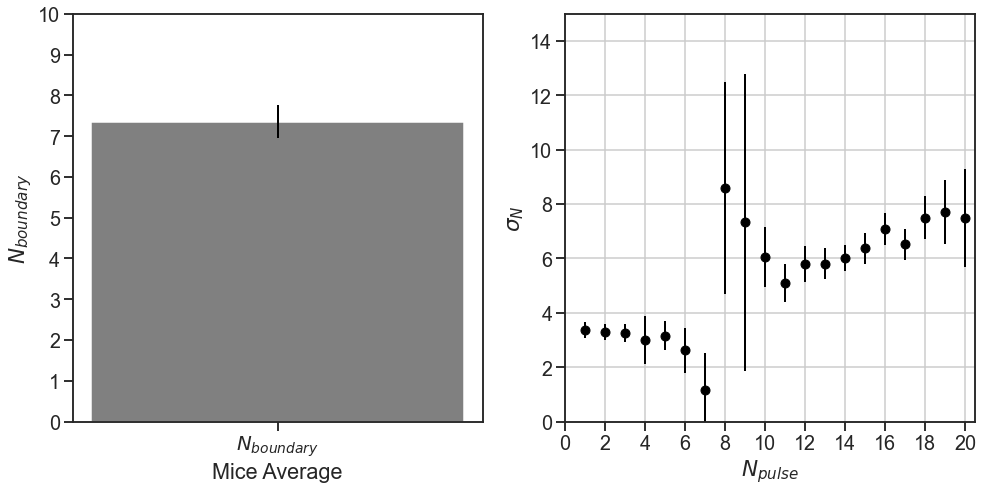

In [48]:
# plot noise estimation result
fig = plt.figure(figsize=(25,7.5))
#fig.suptitle('MLE estimation of pulse estimation noise pooled across animals',size=25)
plt.subplot(1,3,2)
Nb_array = np.zeros((1,2))
sig_dN_array = np.zeros((1,2))
for i in range(1):
    plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1],marker='o',color='black',linestyle = '')
    Nb_array[i,:] = resx_pool[0,:]
    sig_dN_array[i,:] = resx_pool[1,:]
plt.xticks(np.linspace(0,20,11))
plt.xlabel('$N_{pulse}$')
plt.ylim(0,15)
plt.xlim(0,20.5)
plt.grid()

plt.ylabel('$\sigma_{N}$')
plt.subplot(1,3,1)
for i in range(1):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color='gray')
    #plt.bar(x=i+2,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color='gray')
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,2),['$N_{boundary}$'])
plt.xlabel('Mice Average')
plt.ylabel('$N_{boundary}$')

#fig.savefig(savepath + 'numeric_approximation_error_estimate_pooled.svg',format='svg')
#fig.savefig(savepath + 'numeric_approximation_error_estimate_pooled.png',format='png')


plt.show()

In [1091]:
print(resx_pool)

[[7.59840251e+00 5.48259589e-01]
 [3.97238112e-06 1.00729990e-04]
 [3.50949457e+00 3.98075025e-01]
 [3.44495396e+00 3.72526780e-01]
 [3.41521738e+00 4.58353930e-01]
 [3.34625560e+00 5.23524719e-01]
 [3.49561518e+00 8.33293982e-01]
 [3.11662128e+00 1.10272922e+00]
 [2.00741358e+00 2.09248099e+00]
 [1.03085502e+01 4.49860635e+00]
 [6.46071804e+00 3.98934248e+00]
 [5.57598798e+00 1.53766690e+00]
 [4.72740793e+00 8.80223477e-01]
 [5.52762787e+00 7.87067669e-01]
 [5.50420430e+00 5.98567645e-01]
 [5.79116233e+00 6.06450852e-01]
 [5.95861307e+00 6.22338415e-01]
 [6.53012106e+00 5.37426684e-01]
 [6.23220798e+00 5.87608850e-01]
 [7.10253876e+00 9.35903594e-01]
 [7.47705690e+00 1.18964599e+00]
 [7.47316832e+00 1.82836478e+00]]


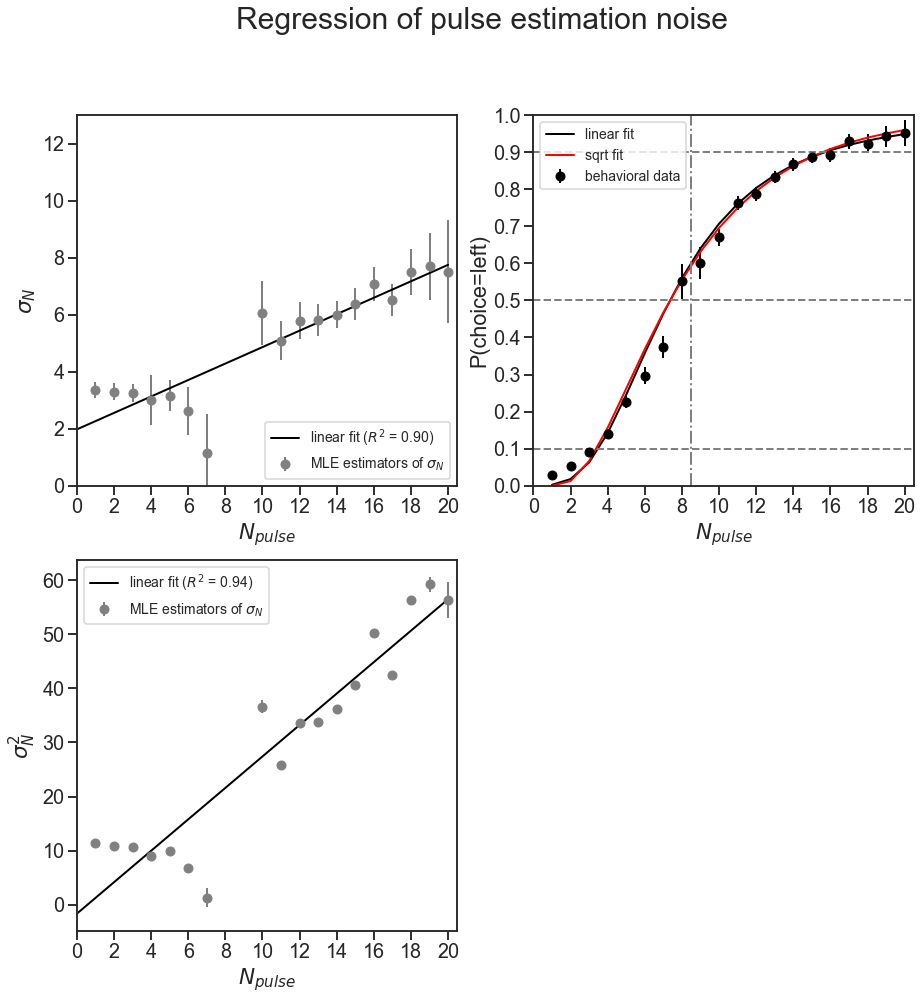

[1.58436476 0.15618084]


In [49]:
x = np.concatenate([np.arange(1,8),np.arange(10,21)])
y = resx_pool[2:,0][x-1]
y_verror = resx_pool[2:,1][x-1]
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_fit = np.linspace(0,20,21).astype(int)
y_fit = x_fit * slope + intercept

def func(x,a, b):
    return a * np.sqrt(x) + b

popt, pcov = curve_fit(func,x,y)
y_pred = func(x_fit,*popt)

c = (y[0:6]-y_pred[0:6])
d =(y[8:]-y_pred[11:])
residuals = np.concatenate((c,d), axis=0)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x,y**2)
y_fit2 = x_fit * slope2 + intercept2

fig = plt.figure(figsize=(15,15))
fig.suptitle('Regression of pulse estimation noise',size=30)

plt.subplot(2,2,1)
plt.errorbar(x,y,color='gray', yerr=y_verror, marker='o', ls='none')#, yerr=resx_pool[2:,1][x-1], marker='o', markeredgecolor='black', markersize=8)
plt.plot(x_fit[0:21],y_fit[0:21],color='black')
#plt.plot(x_fit[0:21],y_pred[0:21],color='red')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,20.5)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value, 'MLE estimators of $\sigma_N$'], loc="lower right") #'sqrt fit ($R^2$ = %.2f)'%r_squared, 
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N$')
plt.ylim(0,13)

#plt.grid()

phigh_est = compute_phigh(np.arange(1,21),resx_pool[0,0],resx_pool[1,0],y_fit[1:21])
phigh_est_sq = compute_phigh(np.arange(1,21),resx_pool[0,0],resx_pool[1,0],y_pred[1:21])

plt.subplot(2,2,2)

plt.errorbar(np.arange(1,21),phigh[0:20,0],phigh[0:20,1],color='black',marker='o',linestyle='') #19
plt.plot(np.arange(1,21),phigh_est,color='black')
plt.plot(np.arange(1,21),phigh_est_sq,color='red')

plt.xticks(np.linspace(0,20,11))#[1:17])
plt.xlim(0,20.5)
plt.legend(['linear fit','sqrt fit', 'behavioral data'])
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=left)')

plt.subplot(2,2,3)
plt.errorbar(x,y**2,color='gray', yerr=(y_verror**2), marker = 'o', ls='none')
plt.plot(x_fit,y_fit2,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,20.5)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value2,'MLE estimators of $\sigma_N$'])
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N^2$')
#plt.ylim(0,169)

#fig.savefig(savepath + 'linreg_noise.svg',format='svg')
#fig.savefig(savepath + 'linreg_noise.png',format='png')

plt.show()

print(popt)

In [15]:
print(slope)
print(slope2)

0.23468902613345094
2.3582415413783826


In [31]:
num_bins_long = 20
half_num_bins_long = 8
min_pulse_long = 1
max_pulse_long = 20

pulse_bins_long = np.linspace(min_pulse_long,max_pulse_long,max_pulse_long-min_pulse_long+1)
phigh_long = np.zeros((num_bins_long,2))
performance_long = np.zeros((num_bins_long,2))
bin_counts_long = np.zeros((num_bins_long,))
pulse_bin_ind_long = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins_long):
    selected = pool_high_choices[pulse_bin_ind_long==pulse_bins_long[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind_long==pulse_bins_long[i]]
    num_selected = len(selected)
    bin_counts_long[i] = num_selected
    phigh_long[i,0] = selected.mean()
    phigh_long[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance_long[i,0] = selected_correct.mean()
    performance_long[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    
print(bin_counts_long)
print(phigh_long)
print(performance_long)

[ 642. 1378. 2026. 2048. 1773. 1201.  751.  312.  368. 1213. 1330. 1416.
 1398. 1209. 1025.  746.  441.  323.  193.  103.]
[[0.02959502 0.01130329]
 [0.05297533 0.01019717]
 [0.08983218 0.01073603]
 [0.13916016 0.01292529]
 [0.22560632 0.01677602]
 [0.29725229 0.02228833]
 [0.37416778 0.02984207]
 [0.55128205 0.04758642]
 [0.60054348 0.04314891]
 [0.67023908 0.02281239]
 [0.76240602 0.01972294]
 [0.78742938 0.01837437]
 [0.83333333 0.01684484]
 [0.86683209 0.01651356]
 [0.88682927 0.01672291]
 [0.89276139 0.01914523]
 [0.92970522 0.02057319]
 [0.92260062 0.02512818]
 [0.94300518 0.02820219]
 [0.95145631 0.0357873 ]]
[[0.97040498 0.01130329]
 [0.94702467 0.01019717]
 [0.91016782 0.01073603]
 [0.86083984 0.01292529]
 [0.77439368 0.01677602]
 [0.70274771 0.02228833]
 [0.62583222 0.02984207]
 [0.44871795 0.04758642]
 [0.60054348 0.04314891]
 [0.67023908 0.02281239]
 [0.76240602 0.01972294]
 [0.78742938 0.01837437]
 [0.83333333 0.01684484]
 [0.86683209 0.01651356]
 [0.88682927 0.01672291]
 

In [50]:
#Modelling noise scaling as the square root of number of pulses

num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
# bound = (0.1,30) #0.6


# bounds = list()
# for i in range(3):
#     bounds.append(bound)
num_batch = num_iter//batch_iter
bounds = [(0.4,50), (0.3, 50), (0.25, 50)]

res_array = np.zeros((3,num_iter))

    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        return -compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig,Nmax=20)

    x0 = 9.5+np.random.rand(3)*5
    
    res = minimize(loss,x0,bounds=bounds) #,method='SLSQP',options={'maxiter':100000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose()

resx_pool_sq =np.zeros((3,2))
resx_pool_sq[:,0] = res_array.mean(1)
resx_pool_sq[:,1] = res_array.std(1)
phigh_est_sq2 = compute_phigh_sq(np.arange(1,21),resx_pool_sq[0,0],resx_pool_sq[1,0],resx_pool_sq[2,0],Nmax=20)
#np.save('resx_pool_sq.npy',resx_pool_sq)
resx_pool_sq

  0%|          | 0/10 [00:00<?, ?it/s]

array([[7.95941013e+00, 1.96287431e-13],
       [3.27473156e+00, 7.77156117e-14],
       [9.73003288e-01, 1.13242749e-14]])

In [51]:
#Modelling noise scaling as linear dependence with number of pulses

num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
# bound = (0.35,50) #(0.35,26)

# bounds = list()
# for i in range(3): #range(3) 
#     bounds.append(bound)
#bounds.append((0,3))
bounds = [(0.4,50), (0.3, 50), (0.25, 50), (0, 0.00001)]
#bounds.append((0,0.001))
num_batch = num_iter//batch_iter

res_array = np.zeros((4,num_iter)) #res_array = np.zeros((3,num_iter))
print(bounds)
    
def worker(x):
    np.random.seed(404)

    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        #sig_0 = 0
        sig_0 = x[3]
        return -compute_logp_correct_lin(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(4)*5 #x0 = 6+np.random.rand(3)*5
    
    res = minimize(loss,x0,bounds=bounds) #,method='SLSQP',options={'maxiter':100000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose() #.reshape(-1,3)

resx_pool_lin =np.zeros((4,2)) #np.zeros((3,2))
resx_pool_lin[:,0] = res_array.mean(1)
resx_pool_lin[:,1] = res_array.std(1)
#np.save('resx_pool_lin.npy',resx_pool_lin)
#compute_phigh_lin(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
phigh_est_lin = compute_phigh_lin(np.arange(1,21),resx_pool_lin[0,0],resx_pool_lin[1,0],
                                  resx_pool_lin[2,0],resx_pool_lin[3,0],Nmax=20)

sig_Np_test_lin = resx_pool_lin[2,0]*(np.arange(1,20+1)) + resx_pool_lin[3,0]

print(sig_Np_test_lin)
resx_pool_lin

[(0.4, 50), (0.3, 50), (0.25, 50), (0, 1e-05)]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.2602123  0.52042461 0.78063691 1.04084921 1.30106152 1.56127382
 1.82148613 2.08169843 2.34191073 2.60212304 2.86233534 3.12254764
 3.38275995 3.64297225 3.90318456 4.16339686 4.42360916 4.68382147
 4.94403377 5.20424607]


array([[7.85490661e+00, 1.61648472e-13],
       [3.46504926e+00, 7.01660952e-14],
       [2.60212304e-01, 3.05311332e-15],
       [0.00000000e+00, 0.00000000e+00]])

In [12]:
resx_pool_lin

array([[7.85490640e+00, 4.17443857e-14],
       [3.46504997e+00, 1.82076576e-14],
       [2.60212405e-01, 3.94129174e-15],
       [0.00000000e+00, 0.00000000e+00]])

In [68]:
#Modelling noise scaling as power law dependence with number of pulses

num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
# bound = (0.5,30) #0.45

# bounds = list()
# for i in range(3):
#     bounds.append(bound)
# bounds.append((0.5,1.2))

bounds = [(0.1,50), (0.1, 50), (0, 50), (0, 50)]
num_batch = num_iter//batch_iter

res_array = np.zeros((4,num_iter))

    
def worker(x):
    np.random.seed(404)

    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        ind = x[3]
        return -compute_logp_correct_pow(choices,Nps,Nb,sig_dN,ksig,ind,Nmax=20)

    x0 = 4+np.random.rand(4)*3
    
    res = minimize(loss,x0,bounds=bounds, method="SLSQP",options={'maxiter':100})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose()

resx_pool_pow =np.zeros((4,2))
resx_pool_pow[:,0] = res_array.mean(1)
resx_pool_pow[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
phigh_est_pow = compute_phigh_pow(np.arange(1,21),resx_pool_pow[0,0],resx_pool_pow[1,0],
                                  resx_pool_pow[2,0],resx_pool_pow[3,0],Nmax=20)
resx_pool_pow

  0%|          | 0/10 [00:00<?, ?it/s]

array([[8.03067763e+00, 6.74023853e-15],
       [3.73852771e+00, 1.70879287e-15],
       [1.63756298e-03, 1.03137590e-18],
       [2.80649971e+00, 3.25145309e-15]])

In [53]:
#Modelling noise scaling as constant variance

num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
bound = (0.1,30) #0.3, 26


bounds = list()
bound2 = (0.5,20) #26
bounds.append(bound)
bounds.append(bound2)
num_batch = num_iter//batch_iter

res_array = np.zeros((2,num_iter))

    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        return -compute_logp_correct_const(choices,Nps,Nb,sig_dN,Nmax=20)

    x0 = 4+np.random.rand(2)*3
    
    res = minimize(loss,x0,bounds=bounds) #,method='SLSQP', options={'maxiter':100000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,2).transpose()

resx_pool_const =np.zeros((2,2))
resx_pool_const[:,0] = res_array.mean(1)
resx_pool_const[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
phigh_est_const = compute_phigh_const(np.arange(1,21),resx_pool_const[0,0],resx_pool_const[1,0],Nmax=20)
resx_pool_const

  0%|          | 0/10 [00:00<?, ?it/s]

array([[9.03756138e+00, 1.05375560e-14],
       [6.46853529e+00, 1.70879287e-15]])

In [54]:
resx_pool_const

array([[9.03756138e+00, 1.05375560e-14],
       [6.46853529e+00, 1.70879287e-15]])

In [55]:
#Modelling noise scaling as linear dependence with number of pulses + subitizing

def compute_phigh_lin_sub(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = np.concatenate([np.zeros(4),ksig*(np.arange(5,Nmax+1,1))+sig_0])
    sig = np.sqrt(sig_Np**2+sig_dN**2)   #Why this is not multiplied by 2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_lin_sub(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18): 
    sig_Np = np.concatenate([np.zeros(4),ksig*(np.arange(5,Nmax+1,1))+sig_0])
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
#bound = (0.1,30) #(0.35,26)

bounds = [(0.4,50), (0.3, 50), (0.25, 50), (0, 0.00001)]
# for i in range(4): #range(3) 
#     bounds.append(bound)
#bounds.append((0,3))
#bounds.append((0,0.001))
num_batch = num_iter//batch_iter

res_array = np.zeros((4,num_iter)) #res_array = np.zeros((3,num_iter))
#print(bounds)
    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        sig_0 = x[3]
        return -compute_logp_correct_lin_sub(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(4)*5 #x0 = 6+np.random.rand(3)*5
    
    res = minimize(loss,x0,bounds=bounds) #,method='SLSQP',options={'maxiter':100000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose() #.reshape(-1,3)

resx_pool_lin_sub =np.zeros((4,2)) #np.zeros((3,2))
resx_pool_lin_sub[:,0] = res_array.mean(1)
resx_pool_lin_sub[:,1] = res_array.std(1)
phigh_est_lin_sub = compute_phigh_lin_sub(np.arange(1,21),resx_pool_lin_sub[0,0],resx_pool_lin_sub[1,0],
                                  resx_pool_lin_sub[2,0],resx_pool_lin_sub[3,0],Nmax=20)

resx_pool_lin_sub

  0%|          | 0/10 [00:00<?, ?it/s]

array([[7.85462327e+00, 1.24344979e-14],
       [3.54074627e+00, 8.52651283e-14],
       [2.54768352e-01, 2.94209102e-15],
       [0.00000000e+00, 0.00000000e+00]])

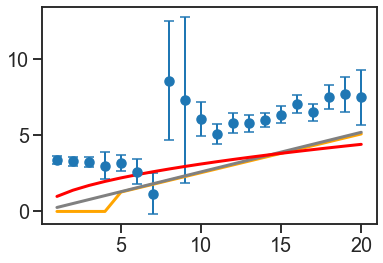

In [58]:
sigma_sub = np.concatenate([np.zeros(4),resx_pool_lin_sub[2,0]*(np.arange(5,21,1))+resx_pool_lin_sub[3,0]]) # 3.8*np.ones(4) #np.zeros(4)
sigma_lin = resx_pool_lin[2,0]*(np.arange(1,21)) + resx_pool_lin[3,0]
sigma_sq = np.sqrt(resx_pool_sq[2,0]*(np.arange(1,21)))

plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1], marker='o',
                 markeredgewidth=1.5,
              linestyle = '', clip_on=False, capsize=5)

plt.plot(pulse_bins[:20],sigma_sub[:20],'orange',linewidth=3)
plt.plot(pulse_bins[:20],sigma_lin[:20],'gray',linewidth=3)
plt.plot(pulse_bins[:20],sigma_sq[:20],'red',linewidth=3)



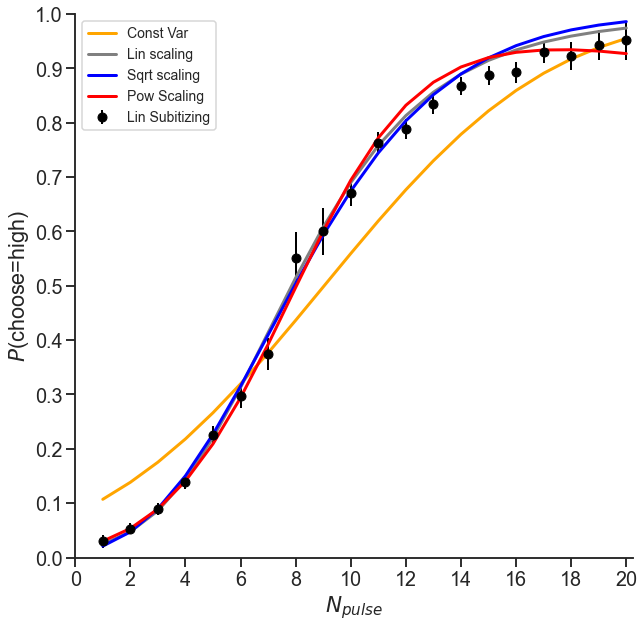

In [69]:
#sns.set_style('white')
#print(phigh)
fig = plt.figure(figsize=(10,10))
#fig.suptitle('Decision psychomatrics of pulse estimation pooled across animals',size=25)
plt.errorbar(x=pulse_bins[:20],y=phigh_long[:20,0],yerr=phigh_long[:20,1],marker='o',color='black',linestyle='')
plt.plot(pulse_bins[:20],phigh_est_const[:20],'orange',linewidth=3)
plt.plot(pulse_bins[:20],phigh_est_lin[:20],'gray',linewidth=3)
plt.plot(pulse_bins[:20],phigh_est_sq2[:20],'blue',linewidth=3)
plt.plot(pulse_bins[:20],phigh_est_pow[:20],'red',linewidth=3)

#plt.plot(pulse_bins[:20],phigh_est_lin_sub[:20],'magenta',linewidth=3)


plt.xlabel('$N_{pulse}$')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0,1)
plt.xlim(0,20.25)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('$P$(choose=high)')
plt.xticks(np.linspace(0,20,11))
plt.legend(['Const Var','Lin scaling','Sqrt scaling','Pow Scaling','Lin Subitizing','Data'])
plt.show()
#fig.savefig('./Images/BNPS/psychometric_fit.svg')

[ 642. 1378. 2026. 2048. 1773. 1201.  751.  312.  368. 1213. 1330. 1416.
 1398. 1209. 1025.  746.  441.  323.  193.  103.]


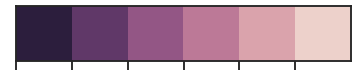

In [70]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))


colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, len(animal_list)))
c_3 = sns.color_palette("tab10", 6)
sns.palplot(sns.cubehelix_palette(reverse=True))

print(bin_counts_long)

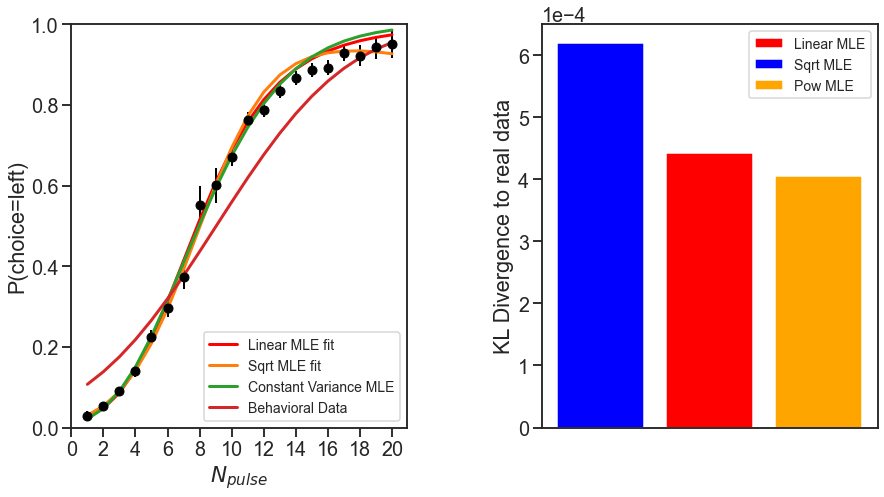

In [71]:
#print(bin_counts_long.shape)

fig = plt.figure(figsize=(14,7))
# #fig.suptitle('Square root MLE fit is the best fit',size=20)
# x_long = np.arange(min_pulse_long,max_pulse_long+1)
# slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x,y**2)
# y_fit_long1 = x_long*slope + intercept
# y_fit_long2 = np.sqrt(x_long*slope2)
# phigh_est_long1 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long1)
# phigh_est_long2 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long2)

# kl1 = entropy(phigh_est_long1*bin_counts_long,phigh_long[:,0]*bin_counts_long)
# kl2 = entropy(phigh_est_long2*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_sq = entropy(phigh_est_sq2*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_lin = entropy(phigh_est_lin*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_pow = entropy(phigh_est_pow*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_const = entropy(phigh_est_const*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_lin_sub = entropy(phigh_est_lin_sub*bin_counts_long,phigh_long[:,0]*bin_counts_long)

plt.subplot(1,2,1)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
#plt.plot(x_long,phigh_est_long1,color=c_3[0], linewidth=3)
#plt.plot(x_long,phigh_est_long2,color=c_3[1], linewidth=3)
plt.plot(x_long,phigh_est_lin,color='red', linewidth=3)
plt.plot(x_long,phigh_est_pow,color=c_3[1], linewidth=3)
plt.plot(x_long,phigh_est_sq2,color=c_3[2], linewidth=3)
plt.plot(x_long,phigh_est_const,color=c_3[3], linewidth=3)

plt.xticks(np.linspace(0,20,11))
plt.ylabel('P(choice=left)')
plt.xlabel('$N_{pulse}$')
plt.legend(['Linear MLE fit', 'Sqrt MLE fit', 'Constant Variance MLE', 'Behavioral Data'], loc='lower right')
plt.ylim(0,1)


plt.subplot(1,2,2)
#plt.bar(1,kl1)
plt.bar(3,kl_lin, color='red')
plt.bar(2,kl_sq, color='blue')
#plt.bar(4,kl_pow,color=c_3[1])
#plt.bar(1,kl_const,color=c_3[3])
plt.bar(4,kl_lin_sub,color='orange')


plt.ylabel('KL Divergence to real data')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
plt.xticks([])
plt.legend(['Linear MLE','Sqrt MLE','Pow MLE','Constant Variance MLE'])
#plt.xticks(np.arange(1,5),['Constant Variance MLE','Sqrt MLE','Linear MLE', 'Power MLE'])

''''
plt.subplot(2,2,1)

plt.plot(x_long,phigh_est_long1)
plt.plot(x_long,phigh_est_long2)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',linestyle='',color='black')
plt.legend(['phigh_est_long1','phigh_est_long2','real data'])
plt.ylim(0,1)
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')

plt.subplot(2,2,4)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
plt.plot(x_long,phigh_est_pow,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['sqrt MLE fit','real data'])
plt.ylim(0,1)


'''
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)



#fig.savefig(savepath +'fit_comparison.svg',format='svg', bbox_inches='tight')
#fig.savefig(savepath +'fit_comparison.png',format='png', bbox_inches='tight')

plt.show()
#print(bin_counts_long)
#print(kl_sq)

In [10]:
import random
num_processes = 16
N_bootstrap = 4000
num_iter = 10000
batch_iter = 100
bound = (0.2,20)


bounds = list()
for i in range(3):
    bounds.append(bound)
num_batch = num_iter//batch_iter
resx_sq_list= list()

for i in range(len(all_correct_trials_list)):
    res_array = np.zeros((3,num_iter))
    all_correct_trials = all_correct_trials_list[i]
    all_high_choices = all_high_choices_list[i]
    all_cum_odor = all_cum_odor_list[i]
    
    def worker(x):
        ind_bootstrap = random.sample(range(0,len(all_correct_trials)),np.round(len(all_correct_trials)*0.8).astype(int))
        #ind_bootstrap = np.random.randint(0,len(all_correct_trials),size=(N_bootstrap,))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]

        choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,16)

        def loss(x):
            Nb = x[0]
            sig_dN = x[1]
            ksig = x[2]
            return -compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig) #square root/

        x0 = 9+np.random.rand(3)*5
        x0[1] = 4 + np.random.rand()*1
        res = minimize(loss,x0,bounds=bounds)
        return res.x

    output = list()

    p = Pool(processes=16)
    for i in tnrange(num_batch):
        batch_output = p.map(worker,range(batch_iter))
        output.extend(batch_output)
    p.close()

    res_array = np.concatenate(output).reshape(-1,3).transpose()

    resx_sq =np.zeros((3,2))
    resx_sq[:,0] = res_array.mean(1)
    resx_sq[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
    resx_sq_list.append(resx_sq)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
for i in range(len(resx_)

plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1], marker='o',
                 markeredgewidth=1.5,
              linestyle = '', clip_on=False, capsize=5)

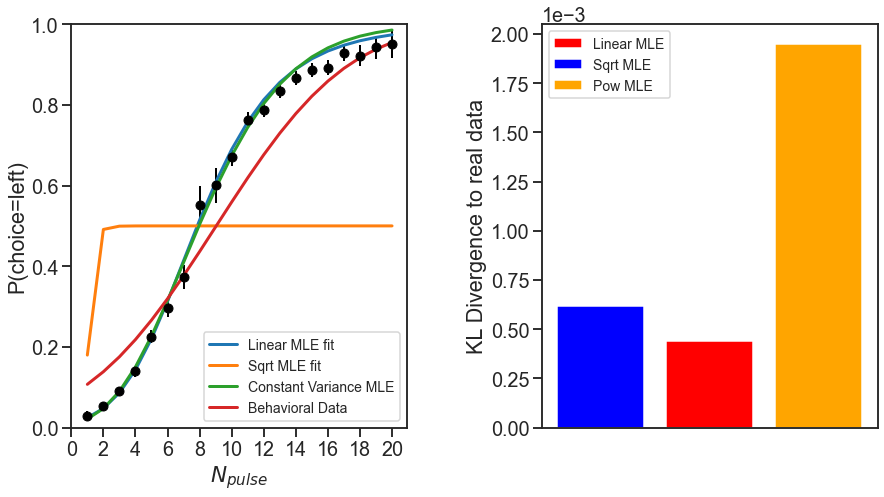

In [29]:
#print(bin_counts_long.shape)

fig = plt.figure(figsize=(14,7))
# #fig.suptitle('Square root MLE fit is the best fit',size=20)
# x_long = np.arange(min_pulse_long,max_pulse_long+1)
# slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x,y**2)
# y_fit_long1 = x_long*slope + intercept
# y_fit_long2 = np.sqrt(x_long*slope2)
# phigh_est_long1 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long1)
# phigh_est_long2 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long2)

# kl1 = entropy(phigh_est_long1*bin_counts_long,phigh_long[:,0]*bin_counts_long)
# kl2 = entropy(phigh_est_long2*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_sq = entropy(phigh_est_sq2*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_lin = entropy(phigh_est_lin*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_pow = entropy(phigh_est_pow*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_const = entropy(phigh_est_const*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_lin_sub = entropy(phigh_est_lin_sub*bin_counts_long,phigh_long[:,0]*bin_counts_long)

plt.subplot(1,2,1)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
#plt.plot(x_long,phigh_est_long1,color=c_3[0], linewidth=3)
#plt.plot(x_long,phigh_est_long2,color=c_3[1], linewidth=3)
plt.plot(x_long,phigh_est_lin,color=c_3[0], linewidth=3)
plt.plot(x_long,phigh_est_pow,color=c_3[1], linewidth=3)
plt.plot(x_long,phigh_est_sq2,color=c_3[2], linewidth=3)
plt.plot(x_long,phigh_est_const,color=c_3[3], linewidth=3)

plt.xticks(np.linspace(0,20,11))
plt.ylabel('P(choice=left)')
plt.xlabel('$N_{pulse}$')
plt.legend(['Linear MLE fit', 'Sqrt MLE fit', 'Constant Variance MLE', 'Behavioral Data'], loc='lower right')
plt.ylim(0,1)


plt.subplot(1,2,2)
#plt.bar(1,kl1)
plt.bar(3,kl_lin, color='red')
plt.bar(2,kl_sq, color='blue')
#plt.bar(4,kl_pow,color=c_3[1])
#plt.bar(1,kl_const,color=c_3[3])
plt.bar(4,kl_lin_sub,color='orange')


plt.ylabel('KL Divergence to real data')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
plt.xticks([])
plt.legend(['Linear MLE','Sqrt MLE','Pow MLE','Constant Variance MLE'])
#plt.xticks(np.arange(1,5),['Constant Variance MLE','Sqrt MLE','Linear MLE', 'Power MLE'])

''''
plt.subplot(2,2,1)

plt.plot(x_long,phigh_est_long1)
plt.plot(x_long,phigh_est_long2)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',linestyle='',color='black')
plt.legend(['phigh_est_long1','phigh_est_long2','real data'])
plt.ylim(0,1)
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')

plt.subplot(2,2,4)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
plt.plot(x_long,phigh_est_pow,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['sqrt MLE fit','real data'])
plt.ylim(0,1)


'''
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)



#fig.savefig(savepath +'fit_comparison.svg',format='svg', bbox_inches='tight')
#fig.savefig(savepath +'fit_comparison.png',format='png', bbox_inches='tight')

plt.show()
#print(bin_counts_long)
#print(kl_sq)

In [789]:
print(resx_sq_list)

[array([[7.71883795e+00, 7.42928609e-03],
       [3.59573398e+00, 1.46375839e-02],
       [1.71294325e+00, 4.05579836e-02]]), array([[7.94686885, 0.011743  ],
       [3.68512683, 0.01714066],
       [2.17324678, 0.06461878]]), array([[7.07874976, 0.01272632],
       [3.34263096, 0.02185429],
       [2.28305805, 0.05228423]]), array([[7.32708352e+00, 3.91990207e-03],
       [3.79350124e+00, 9.27762360e-03],
       [2.15321411e+00, 2.70510835e-02]])]


(20, 2)


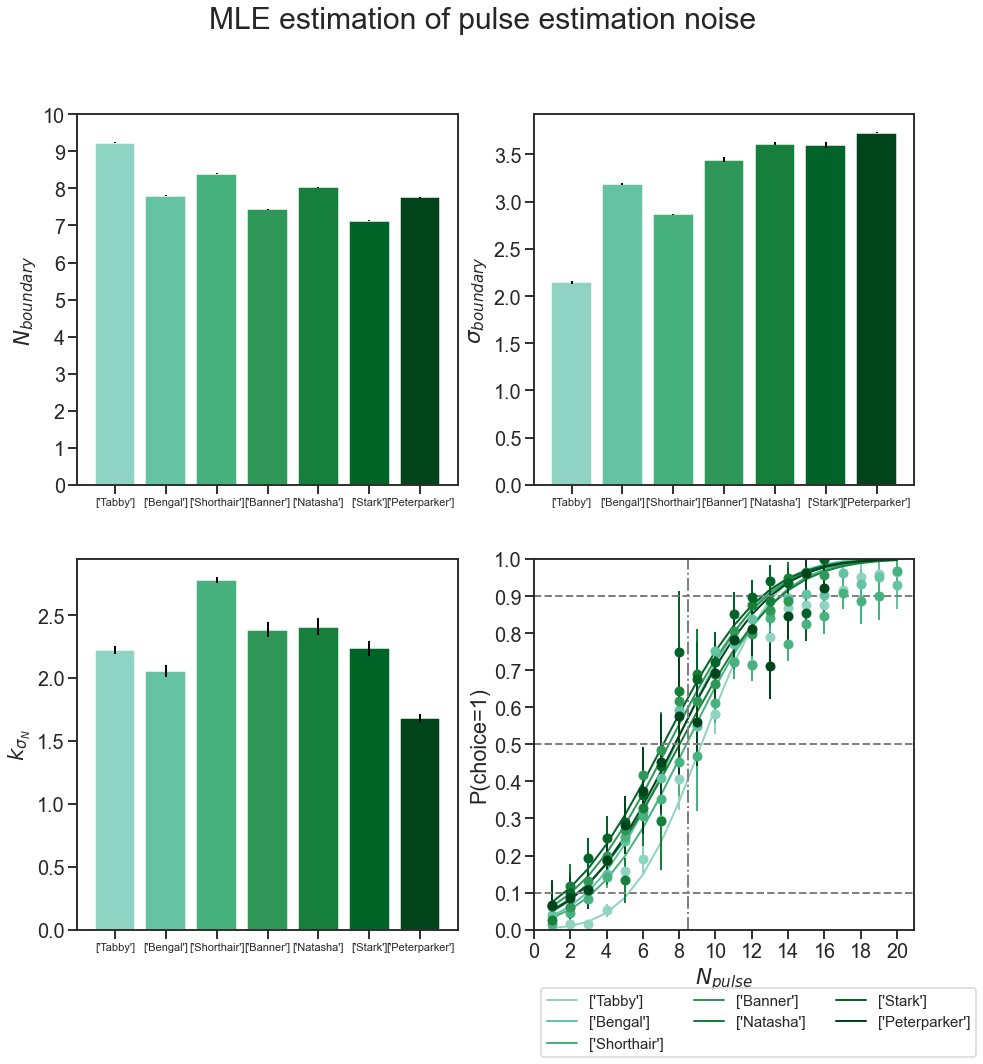

In [790]:
# plot noise estimation result

animals_legend = animal_list
fig = plt.figure(figsize=(15,15))
fig.suptitle('MLE estimation of pulse estimation noise',size=30)

Nb_array = np.zeros((len(resx_sq_list),2))
sig_dN_array = np.zeros((len(resx_sq_list),2))
ksig_array = np.zeros((len(resx_sq_list),2))
for i in range(len(resx_sq_list)):
    resx = resx_sq_list[i]
    Nb_array[i,:] = resx[0,:]
    sig_dN_array[i,:] = resx[1,:]
    ksig_array[i,:] = resx[2,:]

plt.subplot(2,2,1)
for i in range(len(resx_sq_list)):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color=colors[i])
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,8), animals_legend, fontsize=11)
#plt.xlabel('Mouse')
plt.ylabel('$N_{boundary}$')

plt.subplot(2,2,2)
for i in range(len(resx_sq_list)):
    plt.bar(x=i+1,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color=colors[i])
plt.xticks(np.arange(1,8), animals_legend, fontsize=11)
#plt.xlabel('Mouse')
plt.ylabel('$\sigma_{boundary}$')

plt.subplot(2,2,3)
for i in range(len(resx_sq_list)):
    plt.bar(x=i+1,height=ksig_array[i,0],yerr=ksig_array[i,1],color=colors[i])
plt.xticks(np.arange(1,8), animals_legend, fontsize=11)
#plt.xlabel('Mouse')
plt.ylabel('$k_{\sigma_N}$')

print(phigh.shape)
plt.subplot(2,2,4)
for i in range(len(resx_sq_list)):
    resx = resx_sq_list[i]
    phigh = phigh_list[i]
    phigh_est = compute_phigh(np.arange(1,21),resx[0,0],resx[1,0],resx[2:,0])
    plt.plot(np.arange(1,21),phigh_est,color=colors[i])
    plt.errorbar(np.arange(1,21),phigh[:,0],yerr=phigh[:,1],color=colors[i],marker='o',linestyle='')
animals_legend2 = ['Mouse 1 fit','Mouse 2 fit','Mouse 3 fit','Mouse 4 fit','Mouse 1','Mouse 2','Mouse 3','Mouse 4']

plt.legend(animal_list, bbox_to_anchor=(0, -0.25), loc="center left", ncol=3, fontsize='x-small')
plt.xticks(np.linspace(0,20,11))
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')

#fig.savefig('./Images/all/numeric_approximation_error_estimate_sq.svg',format='svg')
#fig.savefig('./Images/all/numeric_approximation_error_estimate_sq.png',format='png')
plt.show()

(18,)
(20,)


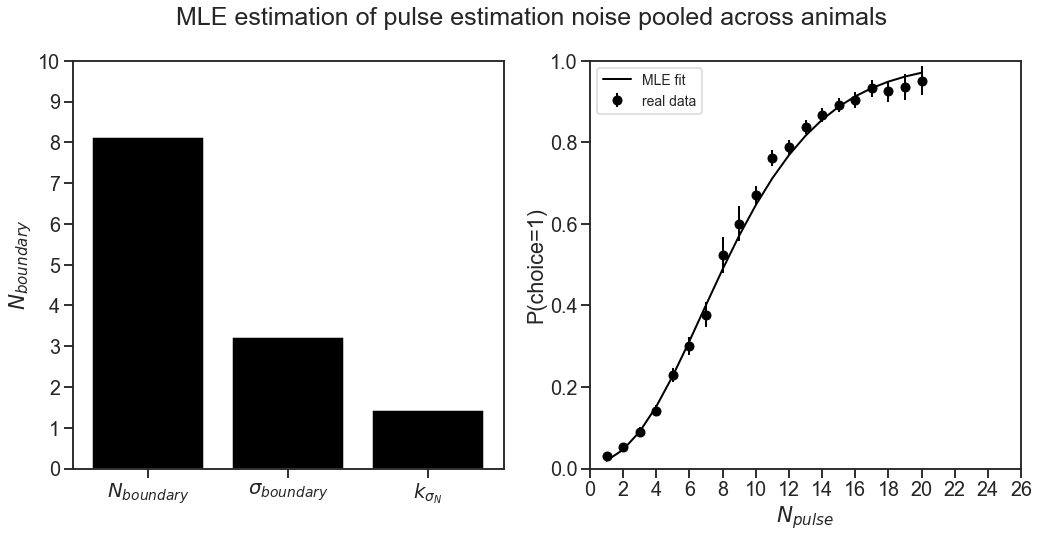

In [793]:
# plot noise estimation result
fig = plt.figure(figsize=(17,7.5))
fig.suptitle('MLE estimation of pulse estimation noise pooled across animals',size=25)

plt.subplot(1,2,1)
for i in range(3):
    plt.bar(x=i+1,height=resx_pool_sq[i,0],yerr=resx_pool_sq[i,1],color='black')
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,4),('$N_{boundary}$','$\sigma_{boundary}$','$k_{\sigma_N}$'))
plt.ylabel('$N_{boundary}$')

plt.subplot(1,2,2)
x_long_2 = np.arange(1,21)
plt.errorbar(x_long,phigh_long[0:20,0],yerr=phigh_long[0:20,1],marker='o',color='black',linestyle='')
plt.plot(x_long_2,phigh_est_sq2,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['MLE fit','real data'])
plt.ylim(0,1)

#fig.savefig('./Images/all/numeric_approximation_error_estimate_pooled.svg',format='svg')
#fig.savefig('./Images/all/numeric_approximation_error_estimate_pooled.png',format='png')
plt.show()

In [619]:
#np.save('resx_pool_sq.npy',resx_pool_sq)

In [620]:
from statsmodels.api import OLS,add_constant
regr_full = OLS(y, x).fit()

In [120]:
regr_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.746
Method:                 Least Squares   F-statistic:                              53.87
Date:                Sun, 25 Sep 2022   Prob (F-statistic):                    1.16e-06
Time:                        17:28:16   Log-Likelihood:                         -51.341
No. Observations:                  18   AIC:                                      104.7
Df Residuals:                      17   BIC:                                      105.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6066      0.083      7.340      0.000       0.432       0.781
==============================================================================
Omnibus:                        4.544   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                1.443
Skew:                           0.093   Prob(JB):                        0.486
Kurtosis:                       1.625   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
from sklearn.linear_model import LinearRegression
x1 = x.reshape(-1,1)
y1 = y.reshape(-1,1)
reg1 = LinearRegression().fit(x1, y1,bin_counts_shrink)
reg1n = LinearRegression(fit_intercept=False).fit(x1, y1,bin_counts_shrink)
reg2 = LinearRegression().fit(x1, y1**2,bin_counts_shrink)
reg2n = LinearRegression(fit_intercept=False).fit(x1, y1**2,bin_counts_shrink)
reg3n = LinearRegression(fit_intercept=False).fit(x1[4:],y1[4:],bin_counts_shrink[4:])

NameError: name 'bin_counts_shrink' is not defined

In [122]:
reg.predict(x1)

NameError: name 'reg' is not defined

NameError: name 'reg1' is not defined

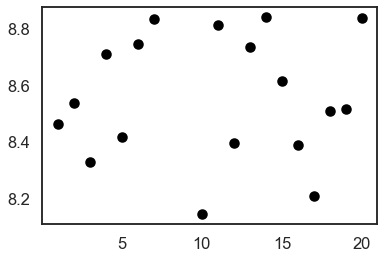

In [123]:
plt.scatter(x,y,color='k')
plt.plot(x1,reg1.predict(x1))
plt.plot(x1,reg1n.predict(x1))
plt.plot(x1,np.sqrt(reg2.predict(x1)))
plt.plot(x1,np.sqrt(reg2n.predict(x1)))
plt.plot(x1,reg3n.predict(x1))
plt.ylim(0,8)
plt.show()

In [124]:
bin_counts_shrink = bin_counts[x-1]

IndexError: index 18 is out of bounds for axis 0 with size 18

In [125]:
phigh_est_sq.shape

(26,)

In [ ]:
choices,Nps = get_pulses(pool_high_choices,pool_cum_odor,1,26)
N = len(choices)
Nb = resx_pool_pow[0,0]
sig_dN = resx_pool_pow[1,0]
ksig = resx_pool_pow[2,0]
ind = resx_pool_pow[3,0]
-2*compute_logp_correct_pow(choices,Nps,Nb,sig_dN,ksig,ind,Nmax=26) + np.log(N)*4

In [ ]:
choices,Nps = get_pulses(pool_high_choices,pool_cum_odor,1,26)
N = len(choices)
Nb = resx_pool_lin[0,0]
sig_dN = resx_pool_lin[1,0]
ksig = resx_pool_lin[2,0]
-2*compute_logp_correct_lin(choices,Nps,Nb,sig_dN,ksig,0,Nmax=26) + np.log(N)*3

In [267]:
choices,Nps = get_pulses(pool_high_choices,pool_cum_odor,1,26)
N = len(choices)
Nb = resx_pool_sq[0,0]
sig_dN = resx_pool_sq[1,0]
ksig = resx_pool_sq[2,0]
-2*compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig,Nmax=26) + np.log(N)*3

11687.952449016033

In [12]:
resx_pool_sq

array([[8.27330736, 0.01550972],
       [2.70921069, 0.0360946 ],
       [1.62938563, 0.02623946]])

In [7]:
np.concatenate(all_correct_trials_list).mean()

0.8257701464540798

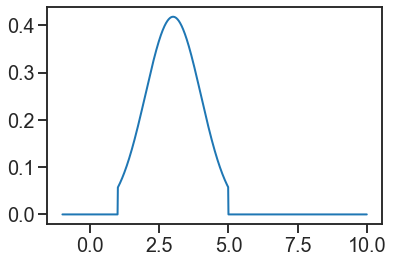

In [1126]:
import scipy as sc

from scipy import stats


myclip_a = 1
myclip_b = 5
my_mean = 3
my_std = 1

# myclip_c = 2
# myclip_d = 3
# my_mean_e = 0.1
# my_std_f = 0.3


a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
c, d = (myclip_c - my_mean_e) / my_std_f, (myclip_d - my_mean_e) / my_std_f

x_range = np.linspace(-1,10,1000)
plt.plot(x_range, sc.stats.truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std))
#plt.plot(x_range, sc.stats.truncnorm.pdf(x_range, c, d, loc = my_mean_e, scale = my_std_f))

plt.savefig(savepath + 'truncated_distribution.svg', format ='svg')